In [10]:
%cd ..
import uproot	
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from mpl_toolkits import mplot3d
import awkward as ak
from scipy.optimize import curve_fit
from scipy import stats
from methods.fit_linear_regression_model import fit_linear_regression_model
import sklearn
import seaborn as sns
import pandas as pd
%matplotlib inline

/auto/work


In [11]:
def round(n, k):
    # function to round number 'n' up/down to nearest 'k'
    # use positive k to round up
    # use negative k to round down

    return n - n % k

In [12]:
file = uproot.open(
    "/work/cetin/Projektpraktikum/tracking_losses_ntuple_B_rad_length_beginVelo2endUT.root:PrDebugTrackingLosses.PrDebugTrackingTool/Tuple;1"
)

# selektiere nur elektronen von B->K*ee
allcolumns = file.arrays()
found = allcolumns[(allcolumns.isElectron) & (~allcolumns.lost) & (allcolumns.fromB)]
lost = allcolumns[(allcolumns.isElectron) & (allcolumns.lost) & (allcolumns.fromB)]

electrons = allcolumns[
    (allcolumns.isElectron)
    & (allcolumns.fromB)
    & (allcolumns.eta <= 5.0)
    & (allcolumns.eta >= 1.5)
    & (np.abs(allcolumns.phi) < 3.142)
]

print(ak.num(found, axis=0), ak.num(lost, axis=0))
print(ak.num(electrons, axis=0))
# ak.count(found, axis=None)

41978 8523
49865


In [13]:
# variables

eta_a = ak.to_numpy(electrons["eta"])
phi_a = ak.to_numpy(electrons["phi"])
rad_length_frac_a = ak.to_numpy(electrons["rad_length_frac"])

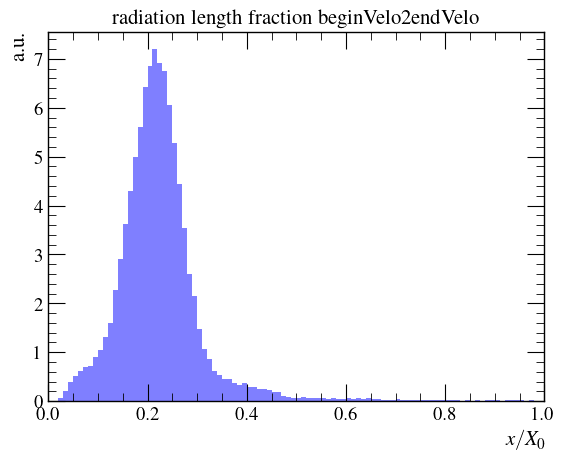

In [14]:
plt.hist(
    rad_length_frac_a,
    bins=100,
    density=True,
    alpha=0.5,
    color="blue",
    histtype="bar",
    range=[0, 1],
)
plt.xlim(0, 1)
# plt.yscale("log")
plt.title("radiation length fraction beginVelo2endUT")
plt.xlabel(f"$x/X_0$")
plt.ylabel("a.u.")
plt.show()

In [15]:
df = pd.DataFrame(
    {
        "phi": phi_a * 90.0 / np.pi,
        "eta": eta_a * 2.0,
        "rad_length_frac": rad_length_frac_a,
    }
)
df = df.round({"phi": 0, "eta": 1, "rad_length_frac": 4})

In [16]:
df_pivoted = df.pivot_table(
    index="eta",
    columns="phi",
    values="rad_length_frac",
    margins=False,
    # fill_value=0,
)

In [17]:
df_pivoted

phi    -90.0    -89.0    -88.0     -87.0   -86.0   -85.0    -84.0   -83.0  \
eta                                                                         
3.1      NaN      NaN      NaN       NaN     NaN     NaN      NaN     NaN   
3.2      NaN      NaN      NaN       NaN     NaN     NaN      NaN     NaN   
3.3      NaN  0.30455      NaN  0.526900     NaN     NaN  0.14755     NaN   
3.4      NaN      NaN      NaN  0.459800  0.1691  0.1710  0.26650     NaN   
3.5      NaN  0.45340  0.35060  0.447200     NaN  0.1885      NaN  0.1711   
...      ...      ...      ...       ...     ...     ...      ...     ...   
9.6      NaN  0.06550  0.09655  0.181325  0.1296     NaN  0.25035  0.0707   
9.7      NaN      NaN      NaN  0.070000  0.0816  0.0878  0.07350  0.0864   
9.8   0.0781  0.09960  0.08180  0.083267  0.0779     NaN  0.08810  0.1684   
9.9      NaN  0.09210  0.08210  0.071900     NaN  0.0936  0.32600  0.0748   
10.0     NaN  0.05840      NaN  0.070600     NaN  0.0578      NaN     NaN   

phi      -82.0   -81.0  ...    81.0    82.0    83.0     84.0    85.0    86.0  \
eta                     ...                                                    
3.1        NaN     NaN  ...     NaN     NaN     NaN      NaN     NaN     NaN   
3.2        NaN     NaN  ...     NaN     NaN     NaN      NaN     NaN     NaN   
3.3   0.135100     NaN  ...  0.1247     NaN     NaN      NaN     NaN     NaN   
3.4   0.291200  0.1778  ...     NaN     NaN     NaN  0.14020  0.1775  0.5234   
3.5   0.243100     NaN  ...  0.2161  0.1313     NaN  0.16210     NaN  0.4284   
...        ...     ...  ...     ...     ...     ...      ...     ...     ...   
9.6        NaN  0.2469  ...     NaN  0.0692  0.2822  0.26520  0.1244     NaN   
9.7        NaN     NaN  ...  0.1993     NaN     NaN  0.14480  0.0652  0.0755   
9.8   0.140867     NaN  ...     NaN  0.0977     NaN  0.13015     NaN     NaN   
9.9   0.193300     NaN  ...  0.0727  0.1494  0.0353      NaN  0.3264     NaN   
10.0       NaN     NaN  ...     NaN  0.0785  0.0915  0.03070     NaN     NaN   

phi     87.0    88.0     89.0   90.0  
eta                                   
3.1      NaN     NaN      NaN    NaN  
3.2      NaN     NaN      NaN    NaN  
3.3      NaN     NaN      NaN    NaN  
3.4   0.1498     NaN  0.14810    NaN  
3.5   0.4008     NaN  0.24475    NaN  
...      ...     ...      ...    ...  
9.6   0.1084  0.1665  0.06750    NaN  
9.7      NaN  0.0796      NaN    NaN  
9.8   0.0821  0.0646  0.08440    NaN  
9.9      NaN  0.0844  0.07660    NaN  
10.0     NaN     NaN  0.07090    NaN  

[70 rows x 181 columns]

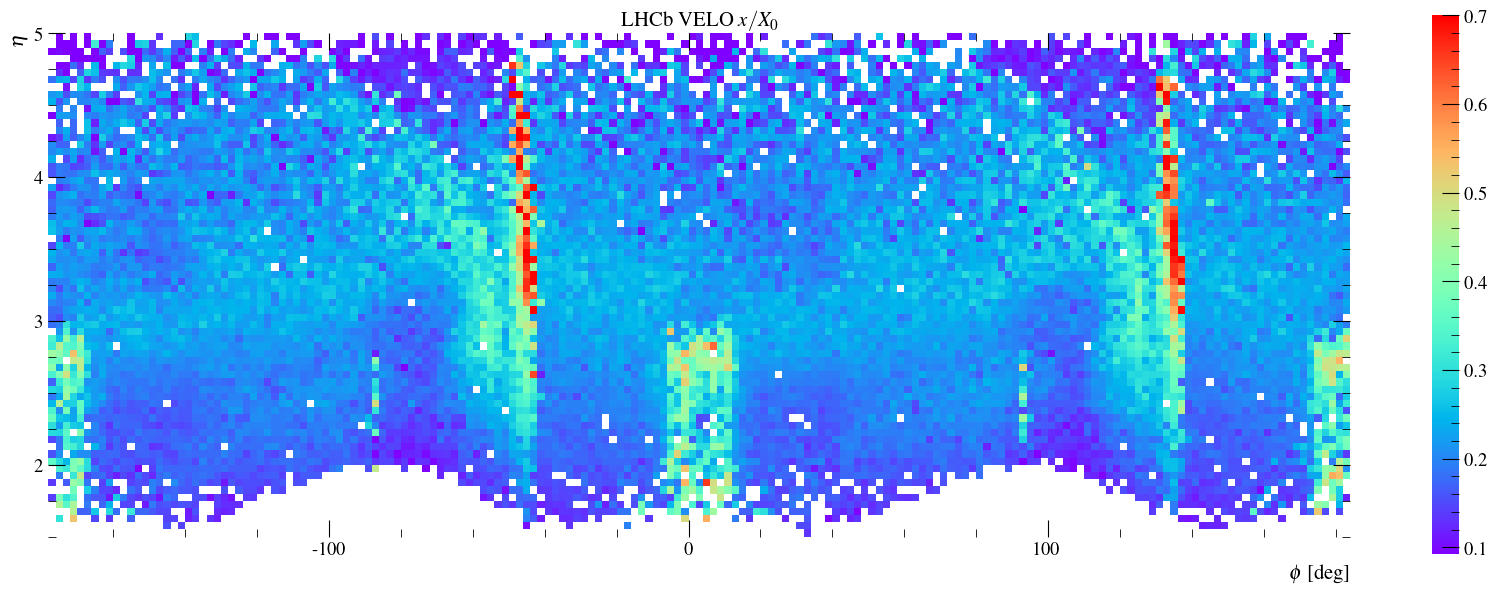

In [18]:
fig = plt.figure(figsize=(21, 7))
ax = sns.heatmap(
    df_pivoted,
    robust=True,
    square=True,
    cmap=colormaps["rainbow"],
    xticklabels=False,
    yticklabels=False,
    vmax=0.7,
)
# ax.set_yticks([5, 15, 25, 35], [2, 3, 4, 5])
ax.set_yticks([10, 30, 50, 70], [2, 3, 4, 5])
ax.set_xticks([39, 89, 139],
              [-100, 0, 100])  # ([79, 179, 279], [-100, 0, 100])
ax.set_xlabel(f"$\phi$ [deg]")
ax.set_ylabel(f"$\eta$")

# ax.set_yticklabels([])
ax.invert_yaxis()
ax.set_title("LHCb VELO+RICH1+UT $x/X_0$")
plt.show()